In [ ]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
positive = [];
pos2 = [];
negative = [];
neg2 = [];


pathp = '/content/drive/MyDrive/1MW/p'
pathn = '/content/drive/MyDrive/1MW/n'
for filename in os.listdir(pathp):
    if filename.endswith('.jpg') :
        # Construct the full file path
        file_path = os.path.join(pathp, filename)

        # Open the image using PIL
        image = Image.open(file_path)

        # Append the image to the list
        positive.append(image)
len(positive)

350

In [ ]:
#Adding some positive examples to help generalize
p = '/content/drive/MyDrive/1MW/Pos2'
addp = [];
for filename in os.listdir(p):
    if filename.endswith('.jpg') :
        # Construct the full file path
        file_path = os.path.join(p, filename)

        # Open the image using PIL
        img = Image.open(file_path)

        # Append the image to the list
        addp.append(img)
len(addp)

#for image in addp:
  #brkp(image,227)

182

In [ ]:
for filename in os.listdir(pathn):
    if filename.endswith('.jpg') :
        # Construct the full file path
        file_path = os.path.join(pathn, filename)

        # Open the image using PIL
        image = Image.open(file_path)

        # Append the image to the list
        negative.append(image)
len(negative)

350

In [ ]:
#Adding excessive negative examples to prevent false positives
n = '/content/drive/MyDrive/1MW/Negi'
addn = [];
for filename in os.listdir(n):
    if filename.endswith('.jpg') :
        # Construct the full file path
        file_path = os.path.join(n, filename)

        # Open the image using PIL
        image = Image.open(file_path)

        # Append the image to the list
        addn.append(image)
len(addn)

206

In [ ]:
def brkn(test_image,size = 227):
    test_image = np.array(test_image)
    h,w= np.shape(test_image)[0],np.shape(test_image)[1]
    h_no = h//size
    w_no = w//size
    h=h_no*size
    w=w_no*size
    for i in range(0,h_no):
        for j in range(0,w_no):
            split = test_image[size*i:size*(i+1),size*j:size*(j+1)]
            neg2.append(split);

def brkp(test_image,size = 227):
    test_image = np.array(test_image)
    h,w= np.shape(test_image)[0],np.shape(test_image)[1]
    h_no = h//size
    w_no = w//size
    h=h_no*size
    w=w_no*size
    for i in range(0,h_no):
        for j in range(0,w_no):
            split = test_image[size*i:size*(i+1),size*j:size*(j+1)]
            pos2.append(split);

In [ ]:
for image in addp:
  brkp(image,227)

for image in addn:
  brkn(image,227)


In [ ]:
images = [];

#Pack positive images and simultaneously labels to prevent mislabeling
for i in range(len(positive)):
  images.append(positive[i])

for i in range(len(pos2)):
  images.append(pos2[i])

labels = [];
for  i in range(len(positive)):
  labels.append('Positive')

for  i in range(len(pos2)):
  labels.append('Positive')


for i in range(len(negative)):
  images.append(negative[i])

for i in range(len(neg2)):
  images.append(neg2[i])

for  i in range(len(negative)):
  labels.append('Negative')

for  i in range(len(neg2)):
  labels.append('Negative')

In [ ]:
def preprocessimg(image):
  a = image
  a = np.array(a)
  a = np.uint8(a)
  gray = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
  blur = cv2.blur(gray, (2,2))
  img_log = (np.log(blur+1)/(np.log(1+np.max(blur))))*255
  img = np.uint8(img_log)
  # bilateral = cv2.bilateralFilter(img, 5, 75, 75)
  blurred = cv2.GaussianBlur(img, (5, 5), 0)
  edges = cv2.Canny(blurred, 45, 110)

  # Find contours and remove areas with large size
  contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  filtered_edges = np.zeros_like(edges)
  max_contour_area = 500  # Adjust this threshold as needed
  for contour in contours:
      area = cv2.contourArea(contour)
      if area < max_contour_area:
          cv2.drawContours(filtered_edges, [contour], -1, 255, thickness=cv2.FILLED)

  kernel = np.ones((11,11), np.uint8)
  closing = cv2.morphologyEx(filtered_edges, cv2.MORPH_CLOSE, kernel)
  return closing

In [ ]:
#Preprocessing the images for better detection accuracy
Imag = [];
for i in range(len(images)):
  Imag.append(preprocessimg(images[i]))

In [ ]:
dataset = {'Images' : Imag , 'Labels' : labels}

In [ ]:
dataset = pd.DataFrame(dataset)
dataset.shape

(1088, 2)

In [ ]:
#Set the input shape
input_shape = (227, 227, 1)

#kernel_size
Wh = 3
Ww = 3

In [ ]:
#Basic CNN
model = Sequential()

model.add(Conv2D(input_shape=input_shape , data_format="channels_last", kernel_size=(Wh,Ww), filters=32, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [ ]:
#set the batch size and number of epochs
batch_size = 50
epochs = 20

In [ ]:
#Modifying the dataset so that the CNN can be trained on it
X = dataset['Images']
y = dataset['Labels']

In [ ]:
for i in range(len(X)):
  a = np.array(X[i]);
  a = a/255
  a = a.reshape((-1,227,227,1))
  X[i] = a

X = np.array(X.tolist())  # Convert Series to NumPy array
X = X.reshape((-1, 227, 227, 1))  # Reshape
#X has images which are processed and ready for input into CNN

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training data into training and validation sets (75% training, 25% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size = batch_size, epochs = epochs, verbose=1)

Epoch 1/20
14/14 [==============================] - 53s 4s/step - loss: 0.5791 - accuracy: 0.7500 - val_loss: 0.4396 - val_accuracy: 0.8716
Epoch 2/20
14/14 [==============================] - 56s 4s/step - loss: 0.4084 - accuracy: 0.8620 - val_loss: 0.2743 - val_accuracy: 0.8761
Epoch 3/20
14/14 [==============================] - 49s 4s/step - loss: 0.3027 - accuracy: 0.9049 - val_loss: 0.4488 - val_accuracy: 0.8899
Epoch 4/20
14/14 [==============================] - 50s 4s/step - loss: 0.3396 - accuracy: 0.8788 - val_loss: 0.2548 - val_accuracy: 0.8716
Epoch 5/20
14/14 [==============================] - 47s 3s/step - loss: 0.3025 - accuracy: 0.8911 - val_loss: 0.2580 - val_accuracy: 0.8853
Epoch 6/20
14/14 [==============================] - 49s 4s/step - loss: 0.2639 - accuracy: 0.9049 - val_loss: 0.3193 - val_accuracy: 0.8624
Epoch 7/20
14/14 [==============================] - 48s 3s/step - loss: 0.2391 - accuracy: 0.9233 - val_loss: 0.2613 - val_accuracy: 0.8945
Epoch 8/20
14/14 [==

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

7/7 [==============================] - 4s 556ms/step - loss: 0.5746 - accuracy: 0.8807
Test accuracy: 0.8807339668273926


In [ ]:
#Make the single image ready for processing by CNN
def modelready(image):
    a = np.array(image)
    a = a/255
    a = a.reshape((227,227,1))
    inp = np.expand_dims(a, axis=0)
    return inp

In [ ]:
def pred(image):
  a = preprocessimg(image)
  b = modelready(a)
  prediction = model.predict(b)
  pred = 1 if prediction > 0.5 else 0
  return(pred)

In [ ]:
#Importing a different image for testing
from PIL import Image
mega = [];
pat = '/content/drive/MyDrive/1MW/TEST'
for filename in os.listdir(pat):
    if filename.endswith('.jpg') :
        # Construct the full file path
        file_path = os.path.join(pat, filename)

        # Open the image using PIL
        image = Image.open(file_path)

        # Append the image to the list
        mega.append(image)

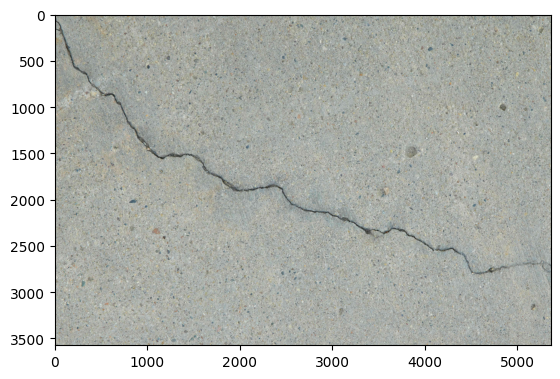

In [ ]:
tes = mega[0]
tes = np.array(tes)
plt.imshow(tes)
plt.show()

In [ ]:
#Approach considering breaking image into pieces and running each part for crack detection
#Function to break image
def break_image(test_image,size):
    test_image = np.array(test_image)
    h,w= np.shape(test_image)[0],np.shape(test_image)[1]
    broken_image = []
    h_no = h//size
    w_no = w//size
    h=h_no*size
    w=w_no*size
    for i in range(0,h_no):
        for j in range(0,w_no):
            split = test_image[size*i:size*(i+1),size*j:size*(j+1)]
            broken_image.append(split);

    return broken_image,h,w,h_no,w_no

In [ ]:
test = [];
size = 227;
test,h,w,h_no,w_no = break_image(tes,size)

In [ ]:
print(w_no)

23


In [ ]:
output_image = np.zeros((h_no*size,w_no*size,1),dtype = np.uint8)

In [ ]:
mat = [];
for image in test:
  result = pred(image)
  mat.append(result)

mat = np.array(mat)
matrix = mat.reshape((h_no,w_no))

1/1 [==============================] - 0s 62ms/step


<ipython-input-9-9d37cfb85753>:7: RuntimeWarning: divide by zero encountered in log
  img_log = (np.log(blur+1)/(np.log(1+np.max(blur))))*255


1/1 [==============================] - 0s 34ms/step


In [ ]:
print(matrix)

[[1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0]
 [1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0]
 [0 1 1 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0]
 [0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0]
 [0 0 1 0 1 1 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 1 1 0 1 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 1 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 1 0 0 1 0 1 1 1 1 1 0 1 0 0]
 [0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0]
 [0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1]
 [0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0]]


In [ ]:
for i in range(0,h_no):
  for j in range(0,w_no):
    a = matrix[i,j]
    output_image[size*i:size*(i+1),size*j:size*(j+1),:] = a

In [ ]:
cropped_image = tes[0:h_no*size,0:w_no*size,:]
pred_image = np.multiply(output_image,cropped_image)

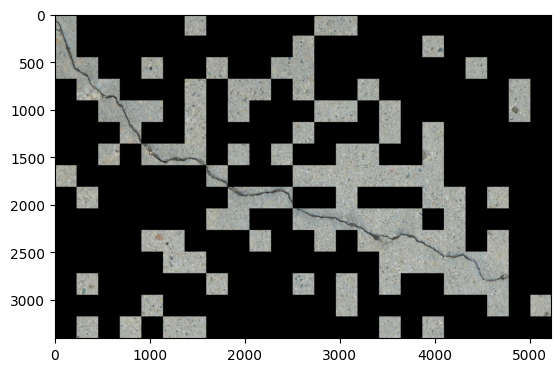

In [ ]:
plt.imshow(pred_image)
plt.show()